In [1]:
from datasets import list_datasets

all_datasets = list_datasets()
len(all_datasets)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12864\4209323366.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


206162

In [2]:
from datasets import load_dataset
emotions = load_dataset('emotion')
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [18]:
train_ds = emotions['train']
print(f"Length of Training dataset: {len(train_ds)}\n")
print(f"Sample Training data: {train_ds[1]} \n")
print(f"Columns are {', '.join(train_ds.column_names)} \n")


Length of Training dataset: 16000

Sample Training data: {'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0} 

Columns are text, label 



In [73]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [46]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

NameError: name 'df' is not defined

In [3]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Class')

NameError: name 'df' is not defined

Text(0.5, 0, '')

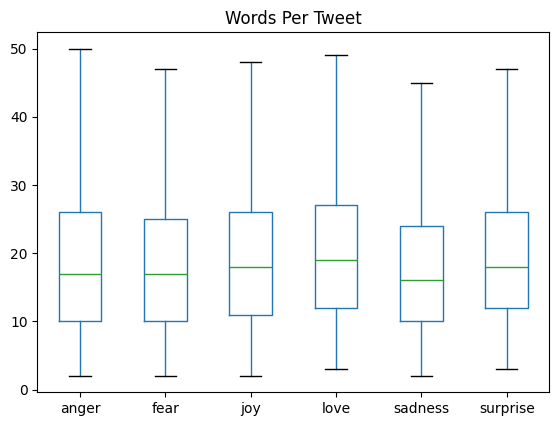

In [40]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False)
plt.suptitle('')
plt.xlabel('')

In [4]:
from transformers import AutoTokenizer

model_ckpt= 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [48]:
text = "Tokenizing text is a core task of NLP"

encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [51]:
tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '[SEP]']

In [5]:
def tokenize(batch):
    tokenized_batch = tokenizer(batch['text'], padding=True, truncation=True)
    tokenized_batch['text'] = batch['text']  # Retain the 'text' column
    tokenized_batch['label'] = batch['label']  # Retain the 'label' column
    return tokenized_batch
tokenize(emotions['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'], 'label': [0, 0]}

In [6]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [7]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [80]:
emotions_encoded['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

In [35]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])              


tensor([0, 0, 3,  ..., 1, 3, 0])

In [9]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=64)
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [10]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [12]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

NameError: name 'lr_clf' is not defined

In [11]:
## Transformer Model

from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [12]:
from huggingface_hub import notebook_login
notebook_login()

In [17]:
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

trainer = Trainer(model=model,args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.8255, 'grad_norm': 4.280139446258545, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3080716133117676, 'eval_accuracy': 0.9115, 'eval_f1': 0.9108255357124816, 'eval_runtime': 10.3062, 'eval_samples_per_second': 194.058, 'eval_steps_per_second': 3.105, 'epoch': 1.0}
{'loss': 0.2479, 'grad_norm': 5.421665191650391, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.21813394129276276, 'eval_accuracy': 0.9235, 'eval_f1': 0.9232765191009696, 'eval_runtime': 10.475, 'eval_samples_per_second': 190.93, 'eval_steps_per_second': 3.055, 'epoch': 2.0}
{'train_runtime': 478.5053, 'train_samples_per_second': 66.875, 'train_steps_per_second': 1.045, 'train_loss': 0.5367318115234375, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5367318115234375, metrics={'train_runtime': 478.5053, 'train_samples_per_second': 66.875, 'train_steps_per_second': 1.045, 'total_flos': 720342861696000.0, 'train_loss': 0.5367318115234375, 'epoch': 2.0})

In [19]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

  0%|          | 0/32 [00:00<?, ?it/s]

{'test_loss': 0.21813394129276276,
 'test_accuracy': 0.9235,
 'test_f1': 0.9232765191009696,
 'test_runtime': 10.5968,
 'test_samples_per_second': 188.737,
 'test_steps_per_second': 3.02}

In [22]:
y_preds = np.argmax(preds_output.predictions, axis=1)

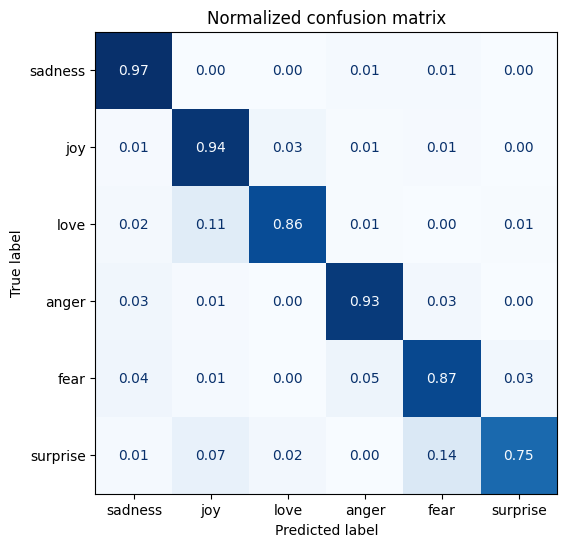

In [36]:
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)




In [44]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction='none')

    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])

emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [47]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [48]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.728541
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.577001
1801,i feel that he was being overshadowed by the s...,love,sadness,5.398590
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.059793
1950,i as representative of everything thats wrong ...,surprise,sadness,4.989831
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.899168
882,i feel badly about reneging on my commitment t...,love,sadness,4.768573
1509,i guess this is a memoir so it feels like that...,joy,fear,4.761091
1111,im lazy my characters fall into categories of ...,joy,fear,4.680084
1683,i had applied for a job and they had assured m...,anger,joy,4.549049


In [49]:
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1725590522.DESKTOP-5EU4T1V.12864.1:   0%|          | 0.00/6.64k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dheerajks/distilbert-base-uncased-finetuned-emotion/commit/4d1cac1968a58dd6941f63c267f58f30310c89f4', commit_message='Training completed!', commit_description='', oid='4d1cac1968a58dd6941f63c267f58f30310c89f4', pr_url=None, pr_revision=None, pr_num=None)

In [50]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--transformersbook--distilbert-base-uncased-finetuned-emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)
preds

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'sadness', 'score': 0.009574249386787415},
  {'label': 'joy', 'score': 0.9667787551879883},
  {'label': 'love', 'score': 0.010558933950960636},
  {'label': 'anger', 'score': 0.0050274343229830265},
  {'label': 'fear', 'score': 0.0035636727698147297},
  {'label': 'surprise', 'score': 0.004497057758271694}]]